# DIP

reference: https://github.com/DmitryUlyanov/deep-image-prior/tree/master

In [1]:
!pip3 install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 658.8 kB/s eta 0:00:00


In [2]:
import os
import torch
import torch.optim
from torch.optim import Adam

from skimage.metrics import peak_signal_noise_ratio as compare_psnr

import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Lambda, Resize
from torchvision.datasets.mnist import FashionMNIST

import random
import imageio
from argparse import ArgumentParser

from tqdm.auto import tqdm

import einops

import torchvision
import sys

import numpy as np
from PIL import Image
import PIL
import numpy as np

import matplotlib.pyplot as plt
from __future__ import print_function
%matplotlib inline

import time

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize =-1
PLOT = True
sigma = 25
sigma_ = sigma/255.

# Setting reproducibility
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Definitions
STORE_PATH_FASHION = f"ddpm_model_fashion.pt"

In [3]:
no_train = False
batch_size = 16
n_epochs = 15
lr = 0.001

store_path = "ddpm_fashion.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\t" + (f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU"))

In [4]:
def get_net(input_depth, NET_TYPE, pad, upsample_mode, n_channels=1, act_fun='LeakyReLU', skip_n33d=128, skip_n33u=128, skip_n11=4, num_scales=5, downsample_mode='stride'):
    if NET_TYPE == 'skip':
        net = skip(input_depth, n_channels, num_channels_down = [skip_n33d]*num_scales if isinstance(skip_n33d, int) else skip_n33d,
                                            num_channels_up =   [skip_n33u]*num_scales if isinstance(skip_n33u, int) else skip_n33u,
                                            num_channels_skip = [skip_n11]*num_scales if isinstance(skip_n11, int) else skip_n11,
                                            upsample_mode=upsample_mode, downsample_mode=downsample_mode,
                                            need_sigmoid=True, need_bias=True, pad=pad, act_fun=act_fun)
    else:
        assert False

    return net

def get_noisy_image(img_np, sigma):
    """Adds Gaussian noise to an image.

    Args:
        img_np: image, np.array with values from 0 to 1
        sigma: std of the noise
    """
    img_noisy_np = np.clip(img_np + np.random.normal(scale=sigma, size=img_np.shape), 0, 1).astype(np.float32)
    img_noisy_pil = np_to_pil(img_noisy_np)

    return img_noisy_pil, img_noisy_np


def crop_image(img, d=32):
    '''Make dimensions divisible by `d`'''

    new_size = (img.size[0] - img.size[0] % d,
                img.size[1] - img.size[1] % d)

    bbox = [
            int((img.size[0] - new_size[0])/2),
            int((img.size[1] - new_size[1])/2),
            int((img.size[0] + new_size[0])/2),
            int((img.size[1] + new_size[1])/2),
    ]

    img_cropped = img.crop(bbox)
    return img_cropped

def get_params(opt_over, net, net_input, downsampler=None):
    '''Returns parameters that we want to optimize over.

    Args:
        opt_over: comma separated list, e.g. "net,input" or "net"
        net: network
        net_input: torch.Tensor that stores input `z`
    '''
    opt_over_list = opt_over.split(',')
    params = []

    for opt in opt_over_list:

        if opt == 'net':
            params += [x for x in net.parameters() ]
        elif  opt=='down':
            assert downsampler is not None
            params = [x for x in downsampler.parameters()]
        elif opt == 'input':
            net_input.requires_grad = True
            params += [net_input]
        else:
            assert False, 'what is it?'

    return params

def get_image_grid(images_np, nrow=8):
    '''Creates a grid from a list of images by concatenating them.'''
    images_torch = [torch.from_numpy(x) for x in images_np]
    torch_grid = torchvision.utils.make_grid(images_torch, nrow)

    return torch_grid.numpy()

def plot_image_grid(images_np, nrow =8, factor=1, interpolation='lanczos'):
    """Draws images in a grid

    Args:
        images_np: list of images, each image is np.array of size 3xHxW or 1xHxW
        nrow: how many images will be in one row
        factor: size if the plt.figure
        interpolation: interpolation used in plt.imshow
    """
    n_channels = max(x.shape[0] for x in images_np)
    # print(n_channels)
    assert (n_channels == 3) or (n_channels == 1), "images should have 1 or 3 channels"

    # images_np = [x if (x.shape[0] == n_channels) else np.concatenate([x, x, x], axis=0) for x in images_np]

    grid = get_image_grid(images_np, nrow)

    plt.figure(figsize=(2 + factor, 2 + factor))

    if images_np[0].shape[0] == 1:
        plt.imshow(grid[0], cmap='gray', interpolation=interpolation)
    else:
        plt.imshow(grid.transpose(1, 2, 0), interpolation=interpolation)

    plt.show()

    return grid

def load(path):
    """Load PIL image."""
    img = Image.open(path)
    return img

def get_image(path, imsize=-1):
    """Load an image and resize to a cpecific size.

    Args:
        path: path to image
        imsize: tuple or scalar with dimensions; -1 for `no resize`
    """
    img = load(path)

    if isinstance(imsize, int):
        imsize = (imsize, imsize)

    if imsize[0]!= -1 and img.size != imsize:
        if imsize[0] > img.size[0]:
            img = img.resize(imsize, Image.BICUBIC)
        else:
            img = img.resize(imsize, Image.ANTIALIAS)

    img_np = pil_to_np(img)

    return img, img_np



def fill_noise(x, noise_type):
    """Fills tensor `x` with noise of type `noise_type`."""
    if noise_type == 'u':
        x.uniform_()
    elif noise_type == 'n':
        x.normal_()
    else:
        assert False

def get_noise(input_depth, method, spatial_size, noise_type='u', var=1./10):
    """Returns a pytorch.Tensor of size (1 x `input_depth` x `spatial_size[0]` x `spatial_size[1]`)
    initialized in a specific way.
    Args:
        input_depth: number of channels in the tensor
        method: `noise` for fillting tensor with noise; `meshgrid` for np.meshgrid
        spatial_size: spatial size of the tensor to initialize
        noise_type: 'u' for uniform; 'n' for normal
        var: a factor, a noise will be multiplicated by. Basically it is standard deviation scaler.
    """
    if isinstance(spatial_size, int):
        spatial_size = (spatial_size, spatial_size)
    if method == 'noise':
        shape = [1, input_depth, spatial_size[0], spatial_size[1]]
        net_input = torch.zeros(shape)

        fill_noise(net_input, noise_type)
        net_input *= var
    else:
        assert False

    return net_input

def pil_to_np(img_PIL):
    '''Converts image in PIL format to np.array.

    From W x H x C [0...255] to C x W x H [0..1]
    '''
    ar = np.array(img_PIL)

    print(ar.shape)

    if len(ar.shape) == 3:
        ar = ar.transpose(2,0,1)
    else:
        ar = ar[None, ...]

    return ar.astype(np.float32) / 255.

def np_to_pil(img_np):
    '''Converts image in np.array format to PIL image.

    From C x W x H [0..1] to  W x H x C [0...255]
    '''
    ar = np.clip(img_np*255,0,255).astype(np.uint8)

    if img_np.shape[0] == 1:
        ar = ar[0]
    else:
        ar = ar.transpose(1, 2, 0)

    return Image.fromarray(ar)

def np_to_torch(img_np):
    '''Converts image in numpy.array to torch.Tensor.

    From C x W x H [0..1] to  1 X C x W x H [0..1]
    '''
    return torch.from_numpy(img_np)[None, :]

def torch_to_np(img_var):
    '''Converts an image in torch.Tensor format to np.array.

    From 1 x C x W x H [0..1] to  C x W x H [0..1]
    '''
    return img_var.detach().cpu().numpy()[0]


def optimize(optimizer_type, parameters, closure, LR, num_iter):
    """Runs optimization loop.

    Args:
        optimizer_type: 'LBFGS' of 'adam'
        parameters: list of Tensors to optimize over
        closure: function, that returns loss variable
        LR: learning rate
        num_iter: number of iterations
    """
    if optimizer_type == 'adam':
        print('Starting optimization with ADAM')
        optimizer = torch.optim.Adam(parameters, lr=LR)

        for j in range(num_iter):
            optimizer.zero_grad()
            closure()
            optimizer.step()
    else:
        assert False


def add_module(self, module):
    self.add_module(str(len(self) + 1), module)

torch.nn.Module.add = add_module

class Concat(nn.Module):
    def __init__(self, dim, *args):
        super(Concat, self).__init__()
        self.dim = dim

        for idx, module in enumerate(args):
            self.add_module(str(idx), module)

    def forward(self, input):
        inputs = []
        for module in self._modules.values():
            inputs.append(module(input))

        inputs_shapes2 = [x.shape[2] for x in inputs]
        inputs_shapes3 = [x.shape[3] for x in inputs]

        if np.all(np.array(inputs_shapes2) == min(inputs_shapes2)) and np.all(np.array(inputs_shapes3) == min(inputs_shapes3)):
            inputs_ = inputs
        else:
            target_shape2 = min(inputs_shapes2)
            target_shape3 = min(inputs_shapes3)

            inputs_ = []
            for inp in inputs:
                diff2 = (inp.size(2) - target_shape2) // 2
                diff3 = (inp.size(3) - target_shape3) // 2
                inputs_.append(inp[:, :, diff2: diff2 + target_shape2, diff3:diff3 + target_shape3])

        return torch.cat(inputs_, dim=self.dim)

    def __len__(self):
        return len(self._modules)

class Swish(nn.Module):
    """
        https://arxiv.org/abs/1710.05941
        The hype was so huge that I could not help but try it
    """
    def __init__(self):
        super(Swish, self).__init__()
        self.s = nn.Sigmoid()

    def forward(self, x):
        return x * self.s(x)


def act(act_fun = 'LeakyReLU'):
    '''
        Either string defining an activation function or module (e.g. nn.ReLU)
    '''
    if isinstance(act_fun, str):
        if act_fun == 'LeakyReLU':
            return nn.LeakyReLU(0.2, inplace=True)
        elif act_fun == 'Swish':
            return Swish()
        elif act_fun == 'ELU':
            return nn.ELU()
        elif act_fun == 'none':
            return nn.Sequential()
        else:
            assert False
    else:
        return act_fun()


class Downsampler(nn.Module):

    def __init__(self, n_planes, factor, kernel_type, phase=0, kernel_width=None, support=None, sigma=None, preserve_size=False):
        super(Downsampler, self).__init__()

        assert phase in [0, 0.5], 'phase should be 0 or 0.5'

        if kernel_type == 'lanczos2':
            support = 2
            kernel_width = 4 * factor + 1
            kernel_type_ = 'lanczos'

        elif kernel_type == 'lanczos3':
            support = 3
            kernel_width = 6 * factor + 1
            kernel_type_ = 'lanczos'

        elif kernel_type == 'gauss12':
            kernel_width = 7
            sigma = 1/2
            kernel_type_ = 'gauss'

        elif kernel_type == 'gauss1sq2':
            kernel_width = 9
            sigma = 1./np.sqrt(2)
            kernel_type_ = 'gauss'

        elif kernel_type in ['lanczos', 'gauss', 'box']:
            kernel_type_ = kernel_type

        else:
            assert False, 'wrong name kernel'


        # note that `kernel width` will be different to actual size for phase = 1/2
        self.kernel = get_kernel(factor, kernel_type_, phase, kernel_width, support=support, sigma=sigma)

        downsampler = nn.Conv2d(n_planes, n_planes, kernel_size=self.kernel.shape, stride=factor, padding=0)
        downsampler.weight.data[:] = 0
        downsampler.bias.data[:] = 0

        kernel_torch = torch.from_numpy(self.kernel)
        for i in range(n_planes):
            downsampler.weight.data[i, i] = kernel_torch

        self.downsampler_ = downsampler

        if preserve_size:

            if  self.kernel.shape[0] % 2 == 1:
                pad = int((self.kernel.shape[0] - 1) / 2.)
            else:
                pad = int((self.kernel.shape[0] - factor) / 2.)

            self.padding = nn.ReplicationPad2d(pad)

        self.preserve_size = preserve_size

    def forward(self, input):
        if self.preserve_size:
            x = self.padding(input)
        else:
            x= input
        self.x = x
        return self.downsampler_(x)

def get_kernel(factor, kernel_type, phase, kernel_width, support=None, sigma=None):
    assert kernel_type in ['lanczos', 'gauss', 'box']

    # factor  = float(factor)
    if phase == 0.5 and kernel_type != 'box':
        kernel = np.zeros([kernel_width - 1, kernel_width - 1])
    else:
        kernel = np.zeros([kernel_width, kernel_width])


    if kernel_type == 'box':
        assert phase == 0.5, 'Box filter is always half-phased'
        kernel[:] = 1./(kernel_width * kernel_width)

    elif kernel_type == 'gauss':
        assert sigma, 'sigma is not specified'
        assert phase != 0.5, 'phase 1/2 for gauss not implemented'

        center = (kernel_width + 1.)/2.
        print(center, kernel_width)
        sigma_sq =  sigma * sigma

        for i in range(1, kernel.shape[0] + 1):
            for j in range(1, kernel.shape[1] + 1):
                di = (i - center)/2.
                dj = (j - center)/2.
                kernel[i - 1][j - 1] = np.exp(-(di * di + dj * dj)/(2 * sigma_sq))
                kernel[i - 1][j - 1] = kernel[i - 1][j - 1]/(2. * np.pi * sigma_sq)
    elif kernel_type == 'lanczos':
        assert support, 'support is not specified'
        center = (kernel_width + 1) / 2.

        for i in range(1, kernel.shape[0] + 1):
            for j in range(1, kernel.shape[1] + 1):

                if phase == 0.5:
                    di = abs(i + 0.5 - center) / factor
                    dj = abs(j + 0.5 - center) / factor
                else:
                    di = abs(i - center) / factor
                    dj = abs(j - center) / factor


                pi_sq = np.pi * np.pi

                val = 1
                if di != 0:
                    val = val * support * np.sin(np.pi * di) * np.sin(np.pi * di / support)
                    val = val / (np.pi * np.pi * di * di)

                if dj != 0:
                    val = val * support * np.sin(np.pi * dj) * np.sin(np.pi * dj / support)
                    val = val / (np.pi * np.pi * dj * dj)

                kernel[i - 1][j - 1] = val


    else:
        assert False, 'wrong method name'

    kernel /= kernel.sum()

    return kernel

def bn(num_features):
    return nn.BatchNorm2d(num_features)


def conv(in_f, out_f, kernel_size, stride=1, bias=True, pad='zero', downsample_mode='stride'):
    downsampler = None
    if stride != 1 and downsample_mode != 'stride':

        if downsample_mode == 'avg':
            downsampler = nn.AvgPool2d(stride, stride)
        elif downsample_mode == 'max':
            downsampler = nn.MaxPool2d(stride, stride)
        elif downsample_mode  in ['lanczos2', 'lanczos3']:
            downsampler = Downsampler(n_planes=out_f, factor=stride, kernel_type=downsample_mode, phase=0.5, preserve_size=True)
        else:
            assert False

        stride = 1

    padder = None
    to_pad = int((kernel_size - 1) / 2)
    if pad == 'reflection':
        padder = nn.ReflectionPad2d(to_pad)
        to_pad = 0

    convolver = nn.Conv2d(in_f, out_f, kernel_size, stride, padding=to_pad, bias=bias)


    layers = filter(lambda x: x is not None, [padder, convolver, downsampler])
    return nn.Sequential(*layers)

def skip(
        num_input_channels=1, num_output_channels=1,
        num_channels_down=[16, 32, 64, 128, 128], num_channels_up=[16, 32, 64, 128, 128], num_channels_skip=[4, 4, 4, 4, 4],
        filter_size_down=3, filter_size_up=3, filter_skip_size=1,
        need_sigmoid=True, need_bias=True,
        pad='zero', upsample_mode='nearest', downsample_mode='stride', act_fun='LeakyReLU',
        need1x1_up=True):
    """Assembles encoder-decoder with skip connections.

    Arguments:
        act_fun: Either string 'LeakyReLU|Swish|ELU|none' or module (e.g. nn.ReLU)
        pad (string): zero|reflection (default: 'zero')
        upsample_mode (string): 'nearest|bilinear' (default: 'nearest')
        downsample_mode (string): 'stride|avg|max|lanczos2' (default: 'stride')

    """
    assert len(num_channels_down) == len(num_channels_up) == len(num_channels_skip)

    n_scales = len(num_channels_down)

    if not (isinstance(upsample_mode, list) or isinstance(upsample_mode, tuple)) :
        upsample_mode   = [upsample_mode]*n_scales

    if not (isinstance(downsample_mode, list)or isinstance(downsample_mode, tuple)):
        downsample_mode   = [downsample_mode]*n_scales

    if not (isinstance(filter_size_down, list) or isinstance(filter_size_down, tuple)) :
        filter_size_down   = [filter_size_down]*n_scales

    if not (isinstance(filter_size_up, list) or isinstance(filter_size_up, tuple)) :
        filter_size_up   = [filter_size_up]*n_scales

    last_scale = n_scales - 1

    cur_depth = None

    model = nn.Sequential()
    model_tmp = model

    input_depth = num_input_channels
    for i in range(len(num_channels_down)):

        deeper = nn.Sequential()
        skip = nn.Sequential()

        if num_channels_skip[i] != 0:
            model_tmp.add(Concat(1, skip, deeper))
        else:
            model_tmp.add(deeper)

        model_tmp.add(bn(num_channels_skip[i] + (num_channels_up[i + 1] if i < last_scale else num_channels_down[i])))

        if num_channels_skip[i] != 0:
            skip.add(conv(input_depth, num_channels_skip[i], filter_skip_size, bias=need_bias, pad=pad))
            skip.add(bn(num_channels_skip[i]))
            skip.add(act(act_fun))

        # skip.add(Concat(2, GenNoise(nums_noise[i]), skip_part))

        deeper.add(conv(input_depth, num_channels_down[i], filter_size_down[i], 2, bias=need_bias, pad=pad, downsample_mode=downsample_mode[i]))
        deeper.add(bn(num_channels_down[i]))
        deeper.add(act(act_fun))

        deeper.add(conv(num_channels_down[i], num_channels_down[i], filter_size_down[i], bias=need_bias, pad=pad))
        deeper.add(bn(num_channels_down[i]))
        deeper.add(act(act_fun))

        deeper_main = nn.Sequential()

        if i == len(num_channels_down) - 1:
            # The deepest
            k = num_channels_down[i]
        else:
            deeper.add(deeper_main)
            k = num_channels_up[i + 1]

        deeper.add(nn.Upsample(scale_factor=2, mode=upsample_mode[i]))

        model_tmp.add(conv(num_channels_skip[i] + k, num_channels_up[i], filter_size_up[i], 1, bias=need_bias, pad=pad))
        model_tmp.add(bn(num_channels_up[i]))
        model_tmp.add(act(act_fun))


        if need1x1_up:
            model_tmp.add(conv(num_channels_up[i], num_channels_up[i], 1, bias=need_bias, pad=pad))
            model_tmp.add(bn(num_channels_up[i]))
            model_tmp.add(act(act_fun))

        input_depth = num_channels_down[i]
        model_tmp = deeper_main

    model.add(conv(num_channels_up[0], num_output_channels, 1, bias=need_bias, pad=pad))
    if need_sigmoid:
        model.add(nn.Sigmoid())

    return model

100%|██████████| 26421880/26421880 [00:02<00:00, 12262552.63it/s]


Extracting ./datasets/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./datasets/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 211245.41it/s]


Extracting ./datasets/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./datasets/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3848475.70it/s]


Extracting ./datasets/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./datasets/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 20721954.89it/s]


Extracting ./datasets/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./datasets/FashionMNIST/raw

(32, 32)


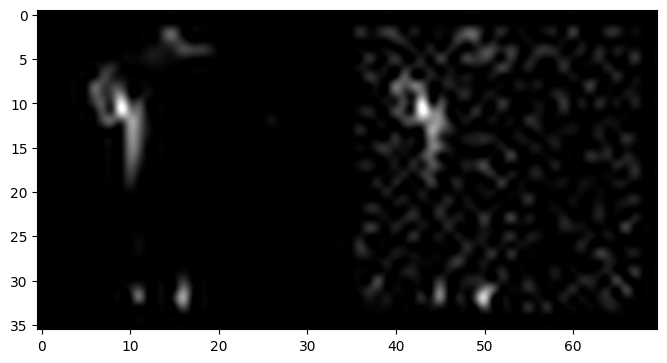

(32, 32)


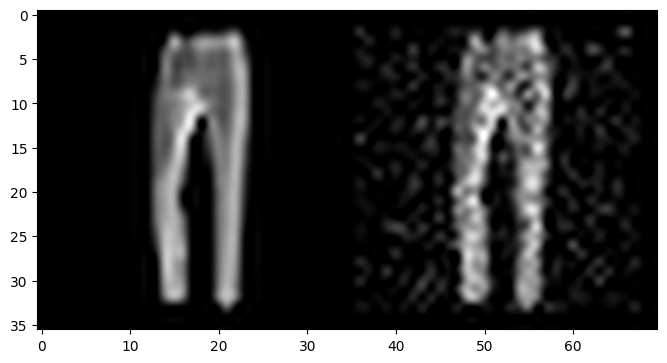

(32, 32)


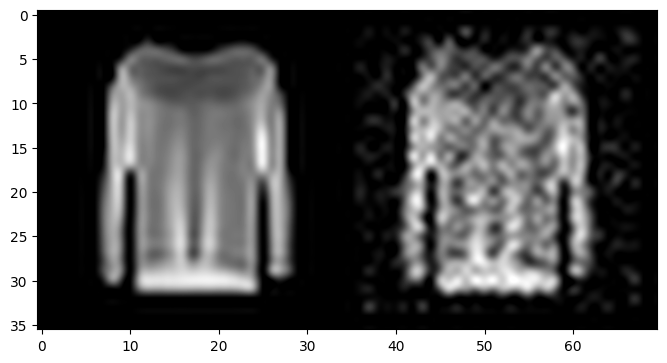

(32, 32)


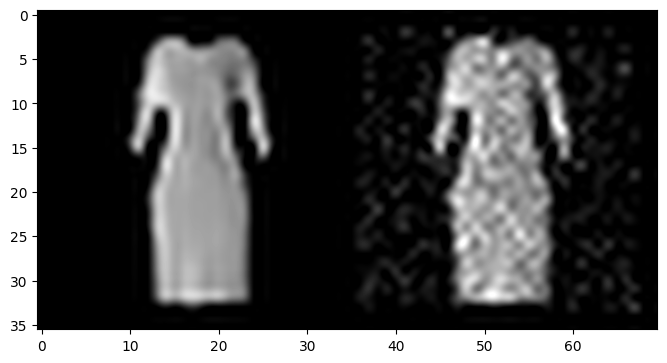

(32, 32)


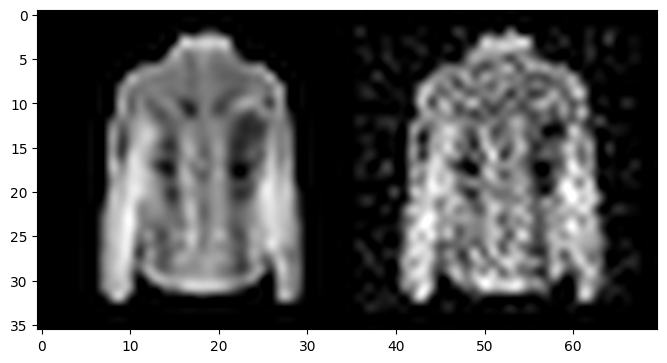

(32, 32)


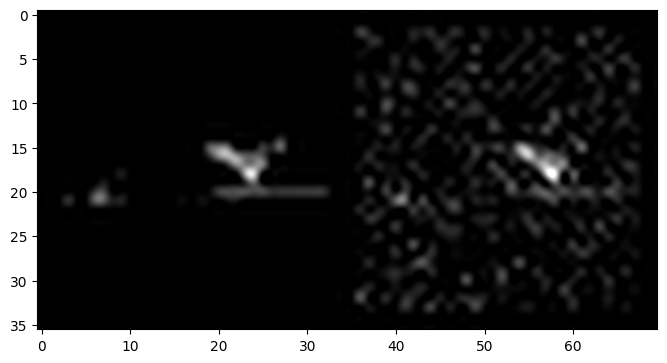

(32, 32)


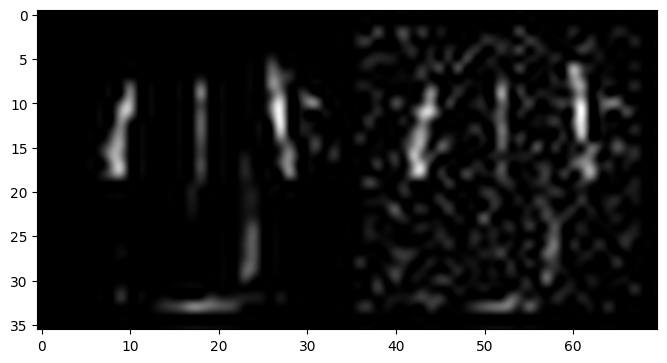

(32, 32)


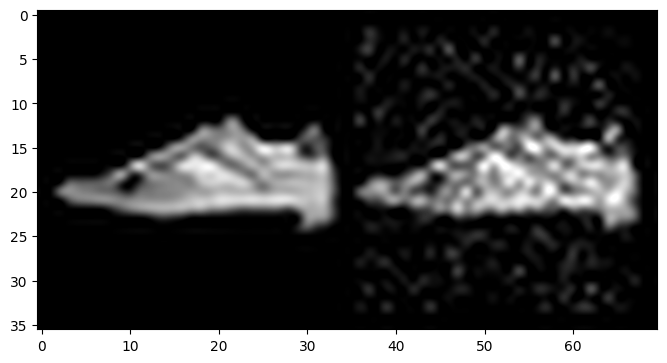

(32, 32)


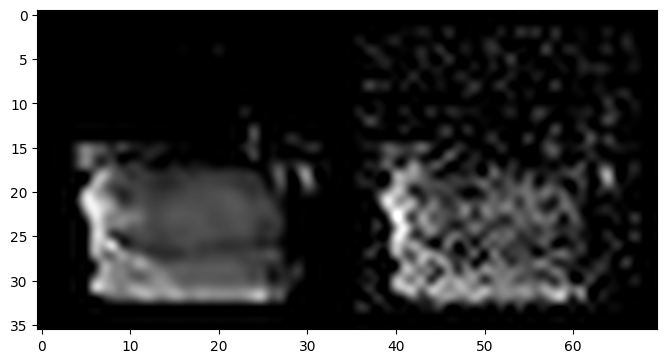

(32, 32)


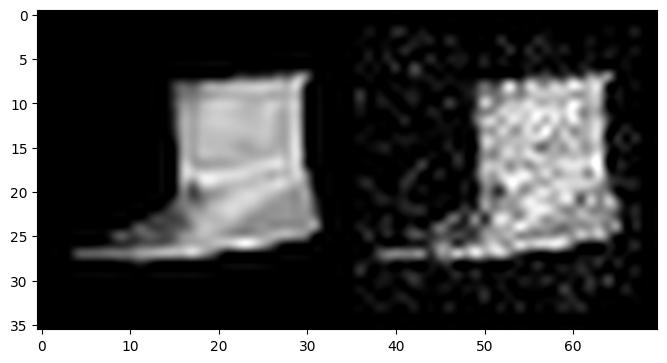

In [5]:
transform = Compose([
    ToTensor(),
    Lambda(lambda x: (x - 0.5) * 2),
    Resize(size=((32,32)))
  ]
)
ds_fn = FashionMNIST
dataset = ds_fn("./datasets", download=True, train=True, transform=transform)
loader = DataLoader(dataset, batch_size, shuffle=True)

images = np.empty((10, 2, 1, 32, 32))
count = 0

for batch in loader:
  labels = batch[1].detach().cpu().numpy()
  # print(labels)
  for l in range(len(labels)):
    if labels[l] == count:
      imgs = batch[0].detach().cpu().numpy()[l]
      img_pil = np_to_pil(imgs)
      img_np = pil_to_np(img_pil)

      img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)

      if PLOT:
          plot_image_grid([img_np, img_noisy_np] , 4, 6);

      img_pair = np.stack([img_np, img_noisy_np], axis=0)

      images[count] = img_pair
      count += 1
      if count == 10: break


Starting optimization with ADAM


<ipython-input-8-472c0cf22fac>:35: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psrn_noisy = compare_psnr(img_noisy_np, out.detach().cpu().numpy()[0])
<ipython-input-8-472c0cf22fac>:36: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psrn_gt    = compare_psnr(img_np, out.detach().cpu().numpy()[0])
<ipython-input-8-472c0cf22fac>:37: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psrn_gt_sm = compare_psnr(img_np, out_avg.detach().cpu().numpy()[0])


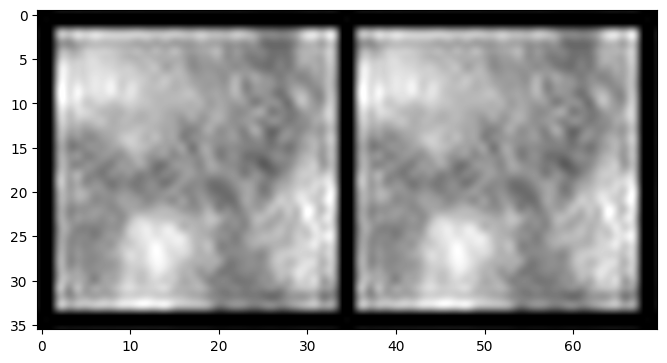

Iteration 0    Loss 0.19115391373634338   PSNR_noisy: 6.487365027526044   PSRN_gt:5.954148288938726  PSNR_gt_sm: 5.954148288938726


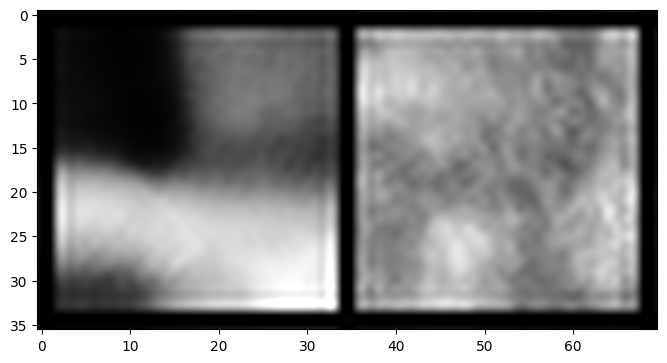

Iteration 2    Loss 0.16051790118217468   PSNR_noisy: 7.103691664210759   PSRN_gt:6.64506529948492  PSNR_gt_sm: 5.9940051778213475
Starting optimization with ADAM


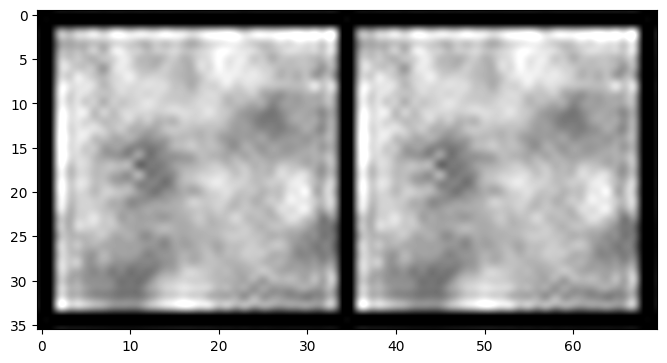

Iteration 0    Loss 0.2324395328760147   PSNR_noisy: 7.272342325015854   PSRN_gt:6.747516903282831  PSNR_gt_sm: 6.747516903282831


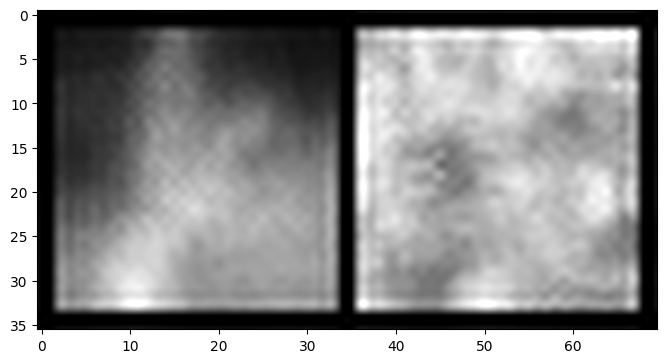

Iteration 2    Loss 0.11055491864681244   PSNR_noisy: 10.622052678327922   PSRN_gt:10.05246520206551  PSNR_gt_sm: 6.801772694496645
Starting optimization with ADAM


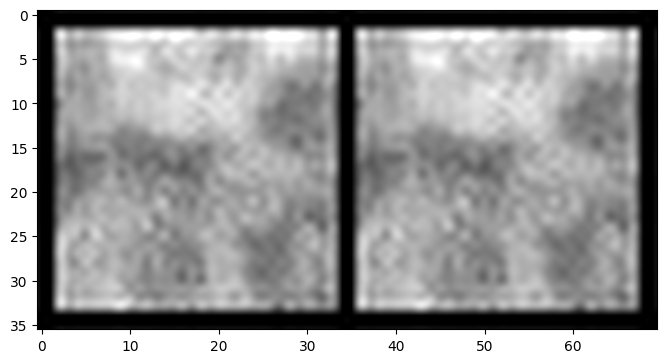

Iteration 0    Loss 0.15722016990184784   PSNR_noisy: 9.149165759707353   PSRN_gt:8.84481446244876  PSNR_gt_sm: 8.84481446244876


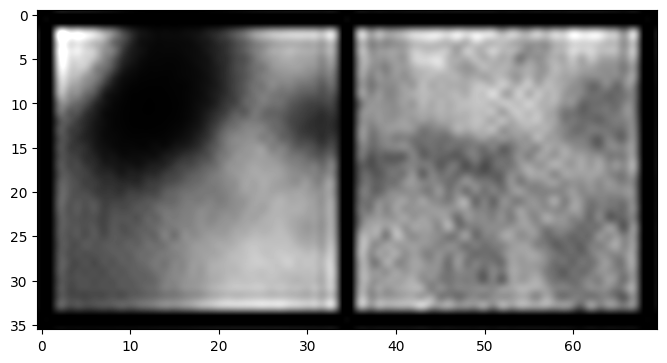

Iteration 2    Loss 0.13557502627372742   PSNR_noisy: 9.0266189171057   PSRN_gt:8.81244470321806  PSNR_gt_sm: 8.881658591974912
Starting optimization with ADAM


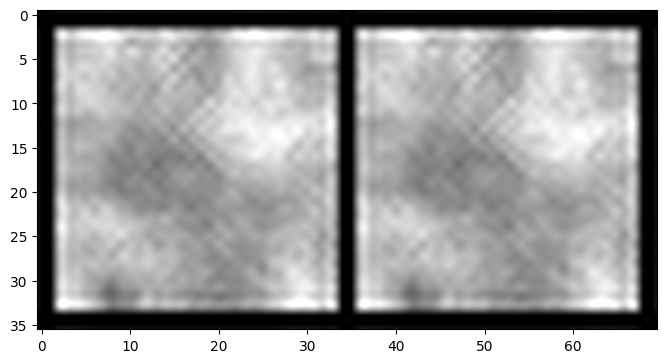

Iteration 0    Loss 0.16734875738620758   PSNR_noisy: 6.830916166610618   PSRN_gt:6.361196153441537  PSNR_gt_sm: 6.361196153441537


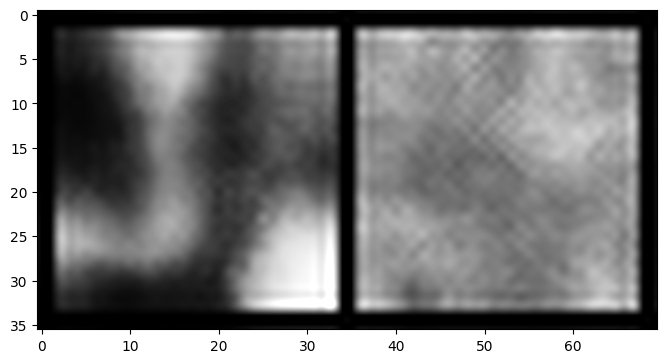

Iteration 2    Loss 0.1516197919845581   PSNR_noisy: 8.023128041890422   PSRN_gt:7.633702875491338  PSNR_gt_sm: 6.404542201039255
Starting optimization with ADAM


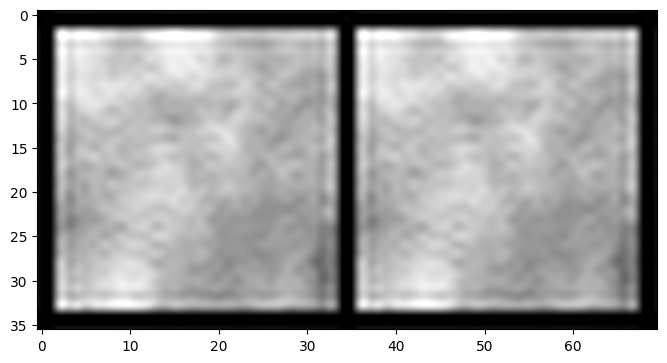

Iteration 0    Loss 0.23027081787586212   PSNR_noisy: 7.519208565578546   PSRN_gt:7.200487863941839  PSNR_gt_sm: 7.200487863941839


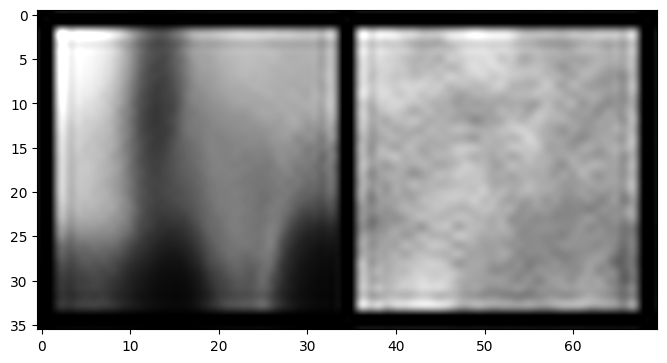

Iteration 2    Loss 0.19869793951511383   PSNR_noisy: 7.6054317509945335   PSRN_gt:7.4300002161076195  PSNR_gt_sm: 7.239462466662475
Starting optimization with ADAM


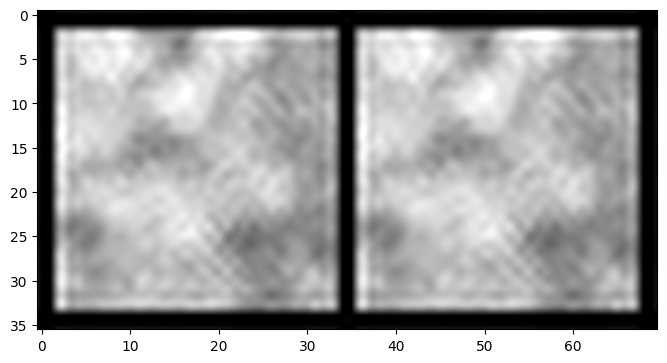

Iteration 0    Loss 0.13394294679164886   PSNR_noisy: 6.075166903266638   PSRN_gt:5.527175659622089  PSNR_gt_sm: 5.527175659622089


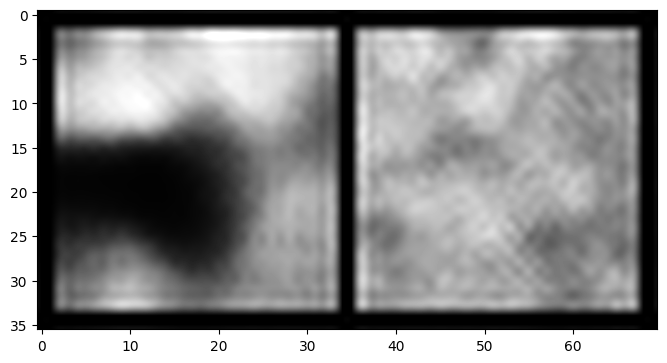

Iteration 2    Loss 0.17124727368354797   PSNR_noisy: 7.109072972759777   PSRN_gt:6.5872652873460655  PSNR_gt_sm: 5.565580401611342
Starting optimization with ADAM


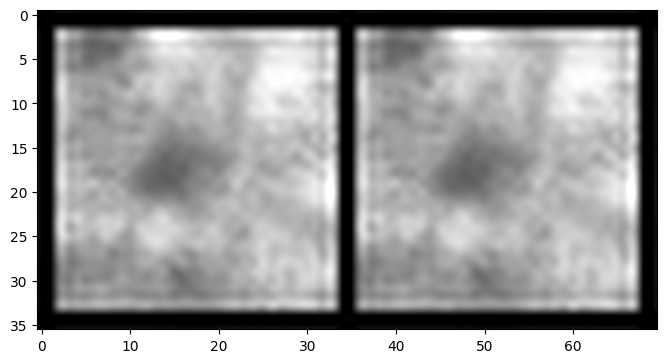

Iteration 0    Loss 0.2068527638912201   PSNR_noisy: 7.069576337069669   PSRN_gt:6.498455502730871  PSNR_gt_sm: 6.498455502730871


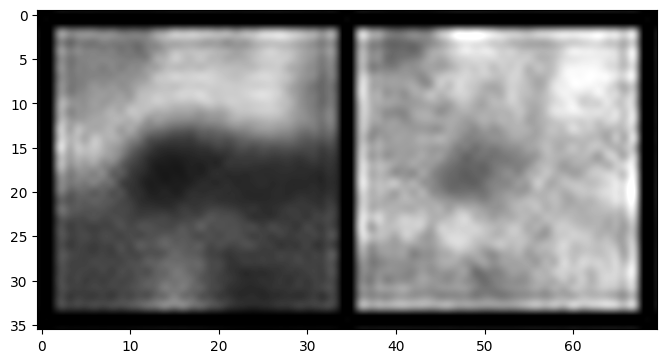

Iteration 2    Loss 0.08956275135278702   PSNR_noisy: 10.91983486180151   PSRN_gt:10.202974944328849  PSNR_gt_sm: 6.554382745091534
Starting optimization with ADAM


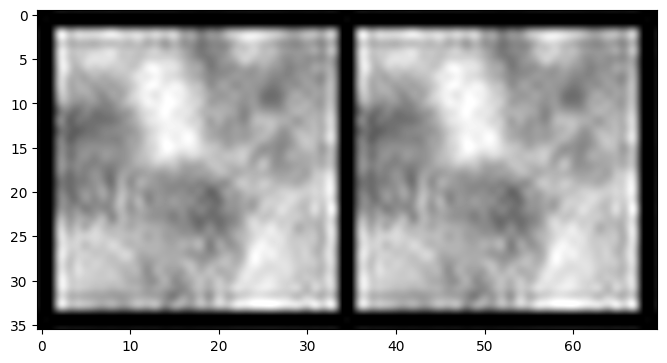

Iteration 0    Loss 0.19179007411003113   PSNR_noisy: 7.619513464985546   PSRN_gt:7.145004980869835  PSNR_gt_sm: 7.145004980869835


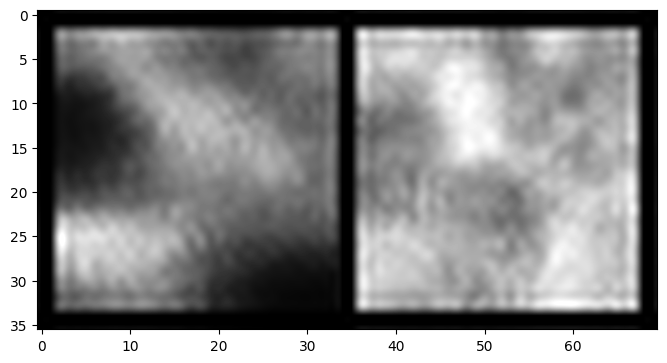

Iteration 2    Loss 0.08445779979228973   PSNR_noisy: 10.68571827199446   PSRN_gt:10.30212950403488  PSNR_gt_sm: 7.2043308392313
Starting optimization with ADAM


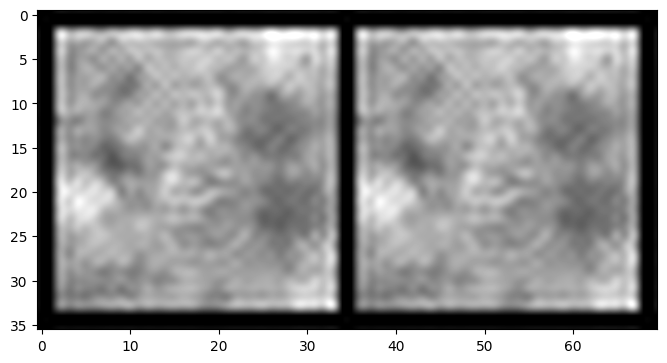

Iteration 0    Loss 0.19374796748161316   PSNR_noisy: 7.578756467876885   PSRN_gt:7.219567161434029  PSNR_gt_sm: 7.219567161434029


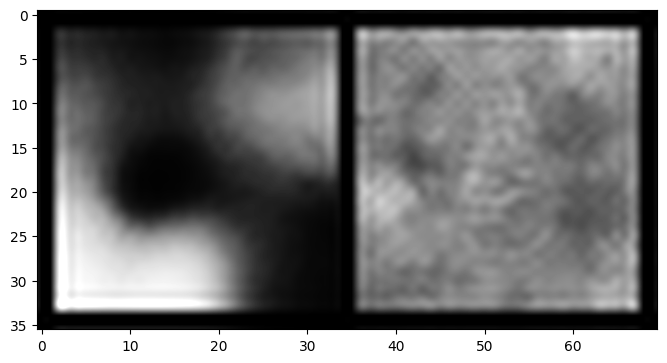

Iteration 2    Loss 0.2165793627500534   PSNR_noisy: 9.039411552147241   PSRN_gt:8.785637636648474  PSNR_gt_sm: 7.2753628604938925
Starting optimization with ADAM


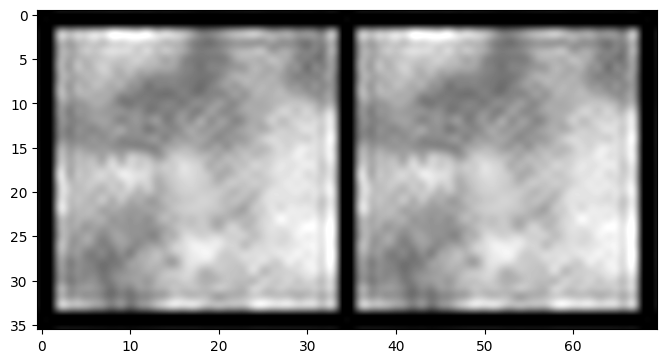

Iteration 0    Loss 0.1944955289363861   PSNR_noisy: 7.462407387133756   PSRN_gt:7.018819443701965  PSNR_gt_sm: 7.018819443701965


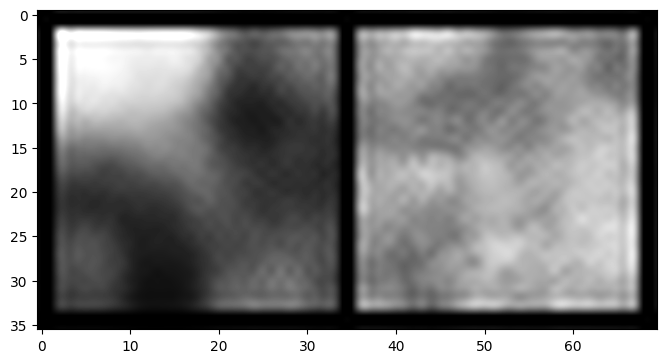

Iteration 2    Loss 0.1457487791776657   PSNR_noisy: 7.127535028203048   PSRN_gt:6.900526217887503  PSNR_gt_sm: 7.05559129844949


In [8]:
# Optimize

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
# net_input_saved = img_noisy_torch.detach().clone()
# noise = img_noisy_torch.detach().clone()
out_avg = None
last_net = None
psrn_noisy_last = 0

# print(net_input.shape)
# print(net_input_saved.shape)
i = 0

def closure():

    global i, out_avg, psrn_noisy_last, last_net, net_input

    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out = net(net_input)

    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)

    total_loss = mse(out, img_noisy_torch)
    total_loss.backward()

    # print(out.detach().cpu().numpy().shape)
    # return
    psrn_noisy = compare_psnr(img_noisy_np, out.detach().cpu().numpy()[0])
    psrn_gt    = compare_psnr(img_np, out.detach().cpu().numpy()[0])
    psrn_gt_sm = compare_psnr(img_np, out_avg.detach().cpu().numpy()[0])

    # Note that we do not have GT for the "snail" example
    # So 'PSRN_gt', 'PSNR_gt_sm' make no sense
    if  PLOT and i % 2 == 0:
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1),
                         np.clip(torch_to_np(out_avg), 0, 1)], 4, 6)

        print (f'Iteration {i}    Loss {total_loss.item()}   PSNR_noisy: {psrn_noisy}   PSRN_gt:{psrn_gt}  PSNR_gt_sm: {psrn_gt_sm}' )


    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5:
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy

    i += 1

    return total_loss

nets = []

for count in range(len(images)):
  # Set up
  INPUT = 'noise'
  pad = 'reflection'
  OPT_OVER = 'net' # 'net,input'

  reg_noise_std = 1./30. # set to 1./20. for sigma=50
  LR = 0.01

  OPTIMIZER='adam'
  show_every = 1 #100
  exp_weight=0.99

  num_iter = 3 # 3000
  input_depth = 1 #32
  figsize = 4


  net = get_net(input_depth, 'skip', pad,
                skip_n33d=128,
                skip_n33u=128,
                skip_n11=4,
                num_scales=3,
                upsample_mode='bilinear').type(dtype)

  net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach()

  # Compute number of parameters
  # s  = sum([np.prod(list(p.size())) for p in net.parameters()]);
  # print ('Number of params: %d' % s)

  # Loss
  mse = torch.nn.MSELoss().type(dtype)

  img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)

  net_input_saved = net_input.detach().clone()
  noise = net_input.detach().clone()
  out_avg = None
  last_net = None
  psrn_noisy_last = 0
  i = 0
  img_noisy_np = images[count][1]
  img_np = images[count][0]

  p = get_params(OPT_OVER, net, net_input)
  optimize(OPTIMIZER, p, closure, LR, num_iter)

  nets.append(net)


Noise

In [ ]:
print(net)

Sequential(
  (1): Concat(
    (0): Sequential(
      (1): Sequential(
        (0): ReflectionPad2d((0, 0, 0, 0))
        (1): Conv2d(3, 4, kernel_size=(1, 1), stride=(1, 1))
      )
      (2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (1): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(3, 128, kernel_size=(3, 3), stride=(2, 2))
      )
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
      (4): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      )
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.2, inplace=True)
      (7): Sequential(
        (1): Concat(
          (0): Sequential(
    

# DDPM

## Loading data
We will use the MNIST (or FashionMNIST) dataset and try to generate some new samples out of (nowhere, but starting from some) random gaussian noise. **NOTE**: It is important to normalize images in range `[-1,1]` and not `[0,1]` as one might usually do. This is because the DDPM network predicts normally distributed noises throughout the denoising process.

In [11]:
# Loading the data (converting each image into a tensor and normalizing between [-1, 1])
transform = Compose([
    ToTensor(),
    Lambda(lambda x: (x - 0.5) * 2),
    Resize(size=((32,32)))
  ]
)
ds_fn = FashionMNIST
dataset = ds_fn("./datasets", download=True, train=True, transform=transform)
loader = DataLoader(dataset, batch_size, shuffle=True)

## Getting device

If you are running this codebook from Google Colab, make sure you are using a GPU runtime. For non-pro users, typically a *Tesla T4* GPU is provided.

In [19]:
# Getting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\t" + (f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU"))

Using device: cuda	Tesla T4


# Defining the DDPM module

We now proceed and define a DDPM PyTorch module. Since in principle the DDPM scheme is independent of the model architecture used in each denoising step, we define a high-level model that is constructed using a `network` parameter, as well as:

- `n_steps`: number of diffusion steps $T$;
- `min_beta`: value of the first $\beta_t$ ($\beta_1$);
- `max_beta`: value of the last  $\beta_t$ ($\beta_T$);
- `device`: device onto which the model is run;
- `image_chw`: tuple contining dimensionality of images.

The `forward` process of DDPMs benefits from a nice property: We don't actually need to slowly add noise step-by-step, but we can directly skip to whathever step $t$ we want using coefficients $\alpha_bar$.

For the `backward` method instead, we simply let the network do the job.

Note that in this implementation, $t$ is assumed to be a `(N, 1)` tensor, where `N` is the number of images in tensor `x`. We thus support different time-steps for multiple images.

In [12]:
# DDPM class
class MyDDPM(nn.Module):
    def __init__(self, network, n_steps=200, min_beta=10 ** -4, max_beta=0.02, device=None, image_chw=(1, 32, 32)):
        super(MyDDPM, self).__init__()
        self.n_steps = n_steps
        self.device = device
        self.image_chw = image_chw
        self.network = network.to(device)
        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(
            device)  # Number of steps is typically in the order of thousands
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)

    def forward(self, x0, t, eta=None):
        # Make input image more noisy (we can directly skip to the desired step)
        n, c, h, w = x0.shape
        a_bar = self.alpha_bars[t]

        if eta is None:
            eta = torch.randn(n, c, h, w).to(self.device)

        noisy = a_bar.sqrt().reshape(n, 1, 1, 1) * x0 + (1 - a_bar).sqrt().reshape(n, 1, 1, 1) * eta
        return noisy

    def backward(self, x, t):
        # Run each image through the network for each timestep t in the vector t.
        # The network returns its estimation of the noise that was added.
        return self.network(x, t)

## Visualizing forward and backward

Now that we have defined the high-level functioning of a DDPM model, we can already define some related utility functions.

In particular, we will be showing the forward process (which is independent of the denoising network) with the `show_forward` method.

We run the backward pass and generate new images with the `generate_new_images` method, but this time we will put more effort into the function and also make it such that a GIF image is created. Notice that in the paper (https://arxiv.org/pdf/2006.11239.pdf) by Ho et. al., two options are considered for $\sigma_t^2$:

- $\sigma_t^2$ = $\beta_t$
- $\sigma_t^2$ = $\frac{1 - \bar{\alpha_{t-1}}}{1 - \bar{\alpha_{t}}} \beta_t$

In this implementation, they are both a few line-comments away. However, the two terms are rougly always the same and little difference is noticeable. By default, I choose the first option out of simplicity.

In [14]:
def generate_new_images(ddpm, n_samples=1, device=None, frames_per_gif=100, gif_name="sampling.gif", c=1, h=32, w=32):
    """Given a DDPM model, a number of samples to be generated and a device, returns some newly generated samples"""
    frame_idxs = np.linspace(0, ddpm.n_steps, frames_per_gif).astype(np.uint)
    frames = []

    s = time.time()

    with torch.no_grad():
        if device is None:
            device = ddpm.device

        # Starting from random noise
        x = torch.randn(n_samples, c, h, w).to(device)

        for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
            # Estimating noise to be removed
            time_tensor = (torch.ones(n_samples, 1) * t).to(device).long()
            eta_theta = ddpm.backward(x, time_tensor)

            alpha_t = ddpm.alphas[t]
            alpha_t_bar = ddpm.alpha_bars[t]

            # Partially denoising the image
            x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta)

            if t > 0:
                z = torch.randn(n_samples, c, h, w).to(device)

                # Option 1: sigma_t squared = beta_t
                beta_t = ddpm.betas[t]
                sigma_t = beta_t.sqrt()

                # Option 2: sigma_t squared = beta_tilda_t
                # prev_alpha_t_bar = ddpm.alpha_bars[t-1] if t > 0 else ddpm.alphas[0]
                # beta_tilda_t = ((1 - prev_alpha_t_bar)/(1 - alpha_t_bar)) * beta_t
                # sigma_t = beta_tilda_t.sqrt()

                # Adding some more noise like in Langevin Dynamics fashion
                x = x + sigma_t * z

            # Adding frames to the GIF
            if idx in frame_idxs or t == 0:
                # Putting digits in range [0, 255]
                normalized = x.clone()
                for i in range(len(normalized)):
                    normalized[i] -= torch.min(normalized[i])
                    normalized[i] *= 255 / torch.max(normalized[i])


                    # fig, ax = plt.subplots(figsize=(0.8, 0.8), dpi=100)

                    # # 显示图像
                    # ax.imshow(np.clip(torch_to_np(normalized[i]),0,255), cmap='gray', interpolation='nearest')
                    # ax.axis('off')  # 关闭坐标轴

                    # plt.show()
                    plt.imshow(np.clip(torch_to_np(normalized[i]),0,255), cmap='gray')
                    # cv2.imwrite("img2.jpg", np.clip(torch_to_np(normalized[i]),0,255))


                # Reshaping batch (n, c, h, w) to be a (as much as it gets) square frame
                # frame = einops.rearrange(normalized, "(b1 b2) c h w -> (b1 h) (b2 w) c", b1=int(n_samples ** 0.5))
                # frame = frame.cpu().numpy().astype(np.uint8)

                # # Rendering frame
                # frames.append(frame)

    f = time.time() - s
    print(f'{f} sec')
    # Storing the gif
    # with imageio.get_writer(gif_name, mode="I") as writer:
    #     for idx, frame in enumerate(frames):
    #         rgb_frame = np.repeat(frame, 3, axis=2)
    #         writer.append_data(rgb_frame)

    #         # Showing the last frame for a longer time
    #         if idx == len(frames) - 1:
    #             last_rgb_frame = np.repeat(frames[-1], 3, axis=2)
    #             for _ in range(frames_per_gif // 3):
    #                 writer.append_data(last_rgb_frame)
    return x

# UNet architecture

Okay great! All that concerns DDPM is down on the table already. So now we simply define an architecture that will be responsible of denoising the we should be good to go... Not so fast! While in principle that's true, we have to be careful to conditioning our model with the temporal information.

Remember that the only term of the loss function that we really care about is $||\epsilon - \epsilon_\theta(\sqrt{\bar{\alpha}_t}x_0 + \sqrt{1 - \bar{\alpha}_t}\epsilon, t)||^2$, where $\epsilon$ is some random noise and $\epsilon_\theta$ is the model's prediction of the noise. Now, $\epsilon_\theta$ is a function of both $x$ and $t$ and we don't want to have a distinct model for each denoising step (thousands of independent models), but instead we want to use a single model that takes as input the image $x$ and the scalar value indicating the timestep $t$.

To do so, in practice we use a sinusoidal embedding (function `sinusoidal_embedding`) that maps each time-step to a `time_emb_dim` dimension. These time embeddings are further mapped with some time-embedding MLPs (function `_make_te`) and added to tensors through the network in a channel-wise manner.

**NOTE:** This UNet architecture is purely arbitrary and was desined to work with 28x28 spatial resolution images.

In [15]:
def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    embedding = torch.zeros(n, d)
    wk = torch.tensor([1 / 10_000 ** (2 * j / d) for j in range(d)])
    wk = wk.reshape((1, d))
    t = torch.arange(n).reshape((n, 1))
    embedding[:,::2] = torch.sin(t * wk[:,::2])
    embedding[:,1::2] = torch.cos(t * wk[:,::2])

    return embedding

In [16]:
class MyBlock(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super(MyBlock, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        return out

In [17]:
class MyUNet(nn.Module):
    def __init__(self, n_steps=1000, time_emb_dim=100):
        super(MyUNet, self).__init__()

        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        # First half
        self.te1 = self._make_te(time_emb_dim, 1)
        self.b1 = nn.Sequential(
            MyBlock((1, 32, 32), 1, 10),
            MyBlock((10, 32, 32), 10, 10),
            MyBlock((10, 32, 32), 10, 10)
        )
        self.down1 = nn.Conv2d(10, 10, 4, 2, 1)

        self.te2 = self._make_te(time_emb_dim, 10)
        self.b2 = nn.Sequential(
            MyBlock((10, 16, 16), 10, 20),
            MyBlock((20, 16, 16), 20, 20),
            MyBlock((20, 16, 16), 20, 20)
        )
        self.down2 = nn.Conv2d(20, 20, 4, 2, 1)

        self.te3 = self._make_te(time_emb_dim, 20)
        self.b3 = nn.Sequential(
            MyBlock((20, 8, 8), 20, 40),
            MyBlock((40, 8, 8), 40, 40),
            MyBlock((40, 8, 8), 40, 40)
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(40, 40, 2, 1, 1),
            nn.SiLU(),
            nn.Conv2d(40, 40, 4, 2, 1)
        )

        # Bottleneck
        self.te_mid = self._make_te(time_emb_dim, 40)
        self.b_mid = nn.Sequential(
            MyBlock((40, 4, 4), 40, 20),
            MyBlock((20, 4, 4), 20, 20),
            MyBlock((20, 4, 4), 20, 40)
        )

        # Second half
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(40, 40, 4, 2, 1, output_padding=1),
            nn.SiLU(),
            nn.ConvTranspose2d(40, 40, 2, 1, 1)
        )

        self.te4 = self._make_te(time_emb_dim, 80)
        self.b4 = nn.Sequential(
            MyBlock((80, 8, 8), 80, 40),
            MyBlock((40, 8, 8), 40, 20),
            MyBlock((20, 8, 8), 20, 20)
        )

        self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        self.te5 = self._make_te(time_emb_dim, 40)
        self.b5 = nn.Sequential(
            MyBlock((40, 16, 16), 40, 20),
            MyBlock((20, 16, 16), 20, 10),
            MyBlock((10, 16, 16), 10, 10)
        )

        self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        self.te_out = self._make_te(time_emb_dim, 20)
        self.b_out = nn.Sequential(
            MyBlock((20, 32, 32), 20, 10),
            MyBlock((10, 32, 32), 10, 10),
            MyBlock((10, 32, 32), 10, 10, normalize=False)
        )

        self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)

    def forward(self, x, t):
        # x is (N, 2, 32, 32) (image with positional embedding stacked on channel dimension)
        t = self.time_embed(t)
        n = len(x)
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))  # (N, 10, 32, 32)
        out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))  # (N, 20, 16, 16)
        out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))  # (N, 40, 8, 8)

        out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1))  # (N, 40, 4, 4)

        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (N, 80, 8, 8)
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))  # (N, 20, 8, 8)

        out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (N, 40, 16, 16)
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))  # (N, 10, 16, 16)

        out = torch.cat((out1, self.up3(out5)), dim=1)  # (N, 20, 32, 32)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))  # (N, 1, 32, 32)

        out = self.conv_out(out)

        return out

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out)
        )

# Instantiating the model

We are finally done! Now we simply need to instantiate a model, optionally play a bit with it (show forward and backward processes) and write the usual code that defines a training loop for our model. When the model will be done training, we will test it's generative capabilities.

In [39]:
# Defining model
n_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02  # Originally used by the authors
ddpm = MyDDPM(MyUNet(n_steps), n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device)

In [21]:
sum([p.numel() for p in ddpm.parameters()])
# net = nets[0]
print(ddpm.n_steps)

400


# Training loop

The training loop is fairly simple. With each batch of our dataset, we run the forward process on the batch. We use a different timesteps $t$ for each of the `N` images in our `(N, C, H, W)` batch tensor to guarantee more training stability. The added noise is a `(N, C, H, W)` tensor $\epsilon$.

Once we obtained the noisy images, we try to predict $\epsilon$ out of them with our network. We optimize with a simple Mean-Squared Error (MSE) loss.

In [30]:
def training_loop(ddpm, loader, n_epochs, optim, device, display=False, store_path="ddpm_model.pt"):
    mse = nn.MSELoss()
    best_loss = float("inf")
    n_steps = ddpm.n_steps

    for epoch in tqdm(range(n_epochs), desc=f"Training progress", colour="#00ff00"):
        epoch_loss = 0.0
        for step, batch in enumerate(tqdm(loader, leave=False, desc=f"Epoch {epoch + 1}/{n_epochs}", colour="#005500")):
            # Loading data
            x0 = batch[0].to(device)
            y = batch[1].to(device)
            n = len(x0)

            # Picking some noise for each of the images in the batch, a timestep and the respective alpha_bars
            eta = torch.randn_like(x0).to(device)
            t = torch.randint(0, n_steps, (n,)).to(device)

            # Computing the noisy image based on x0 and the time-step (forward process)
            noisy_imgs = ddpm(x0, t, eta)
            # print(noisy_imgs.shape)

            # noisy_imgs = nets[0](noisy_imgs)

            # Getting model estimation of noise based on the images and the time-step
            eta_theta = ddpm.backward(noisy_imgs, t.reshape(n, -1))

            # Optimizing the MSE between the noise plugged and the predicted noise
            loss = mse(eta_theta, eta)
            optim.zero_grad()
            loss.backward()
            optim.step()

            epoch_loss += loss.item() * len(x0) / len(loader.dataset)

        # # Display images generated at this epoch
        # if display:
        #     show_images(generate_new_images(ddpm, device=device), f"Images generated at epoch {epoch + 1}")

        log_string = f"Loss at epoch {epoch + 1}: {epoch_loss:.3f}"

        # Storing the model
        if best_loss > epoch_loss:
            best_loss = epoch_loss
            torch.save(ddpm.state_dict(), store_path)
            log_string += " --> Best model ever (stored)"

        print(log_string)

In [40]:
# Training
store_path = "ddpm_step1000.pt"
if not no_train:
  start_time = time.time()
  training_loop(ddpm, loader, 5, optim=Adam(ddpm.parameters(), lr), device=device, store_path=store_path)
  final_time = time.time()

print(f'time(s): {final_time - start_time}')

Training progress:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/3750 [00:00<?, ?it/s]

Loss at epoch 1: 0.066 --> Best model ever (stored)


Epoch 2/5:   0%|          | 0/3750 [00:00<?, ?it/s]

Loss at epoch 2: 0.041 --> Best model ever (stored)


Epoch 3/5:   0%|          | 0/3750 [00:00<?, ?it/s]

Loss at epoch 3: 0.038 --> Best model ever (stored)


Epoch 4/5:   0%|          | 0/3750 [00:00<?, ?it/s]

Loss at epoch 4: 0.036 --> Best model ever (stored)


Epoch 5/5:   0%|          | 0/3750 [00:00<?, ?it/s]

Loss at epoch 5: 0.035 --> Best model ever (stored)
time(s): 500.6171100139618


# Testing the trained model

Time to check how well our model does. We re-store the best performing model according to our training loss and set it to evaluation mode. Finally, we display a batch of generated images and the relative obtained and nice GIF.

In [41]:
# Loading the trained model
best_model = MyDDPM(MyUNet(n_steps), n_steps=n_steps, device=device)
best_model.load_state_dict(torch.load(store_path, map_location=device))
best_model.eval()
print("Model loaded")

print(f'{int((final_time-start_time)/60)} min {(final_time-start_time)%60} sec')

Model loaded
8 min 20.617110013961792 sec


Generating new images
6.460555553436279 sec


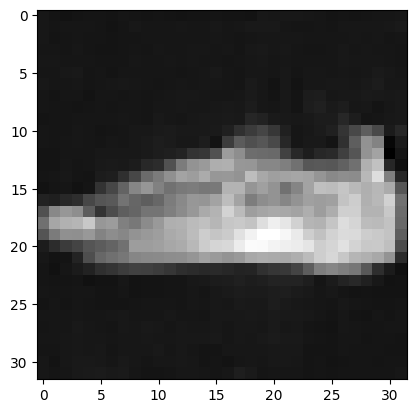

In [42]:
print("Generating new images")
generated = generate_new_images(
        best_model,
        n_samples=1,
        device=device,
        gif_name="fashion.gif"
    )
# show_images(generated, "Final result")



# Visualizing the diffusion

In [ ]:
print(ddpm)

MyDDPM(
  (network): MyUNet(
    (time_embed): Embedding(800, 100)
    (te1): Sequential(
      (0): Linear(in_features=100, out_features=1, bias=True)
      (1): SiLU()
      (2): Linear(in_features=1, out_features=1, bias=True)
    )
    (b1): Sequential(
      (0): MyBlock(
        (ln): LayerNorm((1, 32, 32), eps=1e-05, elementwise_affine=True)
        (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): SiLU()
      )
      (1): MyBlock(
        (ln): LayerNorm((10, 32, 32), eps=1e-05, elementwise_affine=True)
        (conv1): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): SiLU()
      )
      (2): MyBlock(
        (ln): LayerNorm((10, 32, 32), eps=1e-05, elementwise_affine=True)
        (conv1): Conv2d(10, 10, kernel_size=(3, 3), stri